## Steer Function Comparison
In this notebook, we examine the planners using different steer functions.

In [1]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
import matplotlib as mpl
import sys, os
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def benchmark(steer_function: str, settings: [dict]):
    pool = MultipleMPB()
    for setting in settings:
        m = MPB()
        m.update(setting)
        m.set_steer_functions([steer_function])
        m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
        pool.benchmarks.append(m)

### Moving AI Scenarios

In [83]:
scenario = 'Boston_1_1024'
num_scenarios = 50
steer_function = 'reeds_shepp'

scenario_file = '/root/code/mpb/bin/moving_ai_scenarios/%s.map.scen' % scenario
if not os.path.exists(scenario_file):
    raise Exception("Scenario file \"%s\" could not be found." % scenario_file)

config = MPB.get_config()
config["benchmark.moving_ai.active"] = True
config["max_planning_time"] = 60
config["benchmark.moving_ai.create_border"] = False
# use point-based collision model for MovingAI scenarios
config["env.collision.collision_model"] = 0

pool = MultipleMPB()
for i in range(num_scenarios):
    m = MPB()
    config["benchmark.moving_ai.start"] = i - num_scenarios
    config["benchmark.moving_ai.end"] = i - num_scenarios
    config["benchmark.moving_ai.scenario"] = scenario_file    
    m.update(deepcopy(config))
    m.set_steer_functions([steer_function])
    m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
    #     m.set_planners(['theta_star'])
    #     m.set_planners(['sbpl_adstar'])
    pool.benchmarks.append(m)
pool.run_parallel("moving_ai_%s_%s" % (scenario, steer_function), processes=20, limit_memory=True)

Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max']
Selected steer functions: ['reeds_shepp']
Selected smoothers: ['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplif

Benchmark 9 (moving_ai_Boston_1_1024_reeds_shepp_9) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_20 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_20.log)...


Benchmark 1 (moving_ai_Boston_1_1024_reeds_shepp_1) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_21 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_21.log)...


Benchmark 13 (moving_ai_Boston_1_1024_reeds_shepp_13) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_22 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_22.log)...


Benchmark 6 (moving_ai_Boston_1_1024_reeds_shepp_6) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_23 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_23.log)...


Benchmark 0 (moving_ai_Boston_1_1024_reeds_shepp_0) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_24 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_24.log)...


Benchmark 15 (moving_ai_Boston_1_1024_reeds_shepp_15) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_25 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_25.log)...


Benchmark 14 (moving_ai_Boston_1_1024_reeds_shepp_14) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_26 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_26.log)...


Benchmark 10 (moving_ai_Boston_1_1024_reeds_shepp_10) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_27 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_27.log)...


Benchmark 3 (moving_ai_Boston_1_1024_reeds_shepp_3) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_28 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_28.log)...


Benchmark 19 (moving_ai_Boston_1_1024_reeds_shepp_19) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_29 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_29.log)...



Benchmark 8 (moving_ai_Boston_1_1024_reeds_shepp_8) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_30 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_30.log)...


Benchmark 12 (moving_ai_Boston_1_1024_reeds_shepp_12) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_31 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_31.log)...


Benchmark 11 (moving_ai_Boston_1_1024_reeds_shepp_11) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_32 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_32.log)...


Benchmark 17 (moving_ai_Boston_1_1024_reeds_shepp_17) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_33 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_33.log)...


Benchmark 4 (moving_ai_Boston_1_1024_reeds_shepp_4) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_34 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_34.log)...


Benchmark 16 (moving_ai_Boston_1_1024_reeds_shepp_16) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_35 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_35.log)...


Benchmark 2 (moving_ai_Boston_1_1024_reeds_shepp_2) failed. Return code: -6.


Running MPB with ID moving_ai_Boston_1_1024_reeds_shepp_36 (log file at moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_36.log)...


Process ForkPoolWorker-835:
Process ForkPoolWorker-832:
Process ForkPoolWorker-827:
Process ForkPoolWorker-831:
Process ForkPoolWorker-829:
Process ForkPoolWorker-825:
Process ForkPoolWorker-830:
Process ForkPoolWorker-836:
Process ForkPoolWorker-828:
Process ForkPoolWorker-826:
Process ForkPoolWorker-837:
Process ForkPoolWorker-839:
Process ForkPoolWorker-834:
Process ForkPoolWorker-838:
Process ForkPoolWorker-843:
Process ForkPoolWorker-841:
Process ForkPoolWorker-840:
Process ForkPoolWorker-844:
Process ForkPoolWorker-833:
Process ForkPoolWorker-842:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rece

KeyboardInterrupt: 

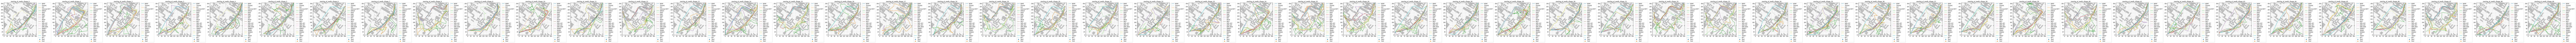

In [19]:
pool.visualize_trajectories(show_legend=True)

Successfully merged [moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_0_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_1_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_2_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_3_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_4_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_5_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_6_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_7_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_8_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_9_results.json, moving_ai_Boston_1_1024_reeds_shepp/moving_ai_Boston_1_1024_reeds_shepp_10_results.json, moving_ai_

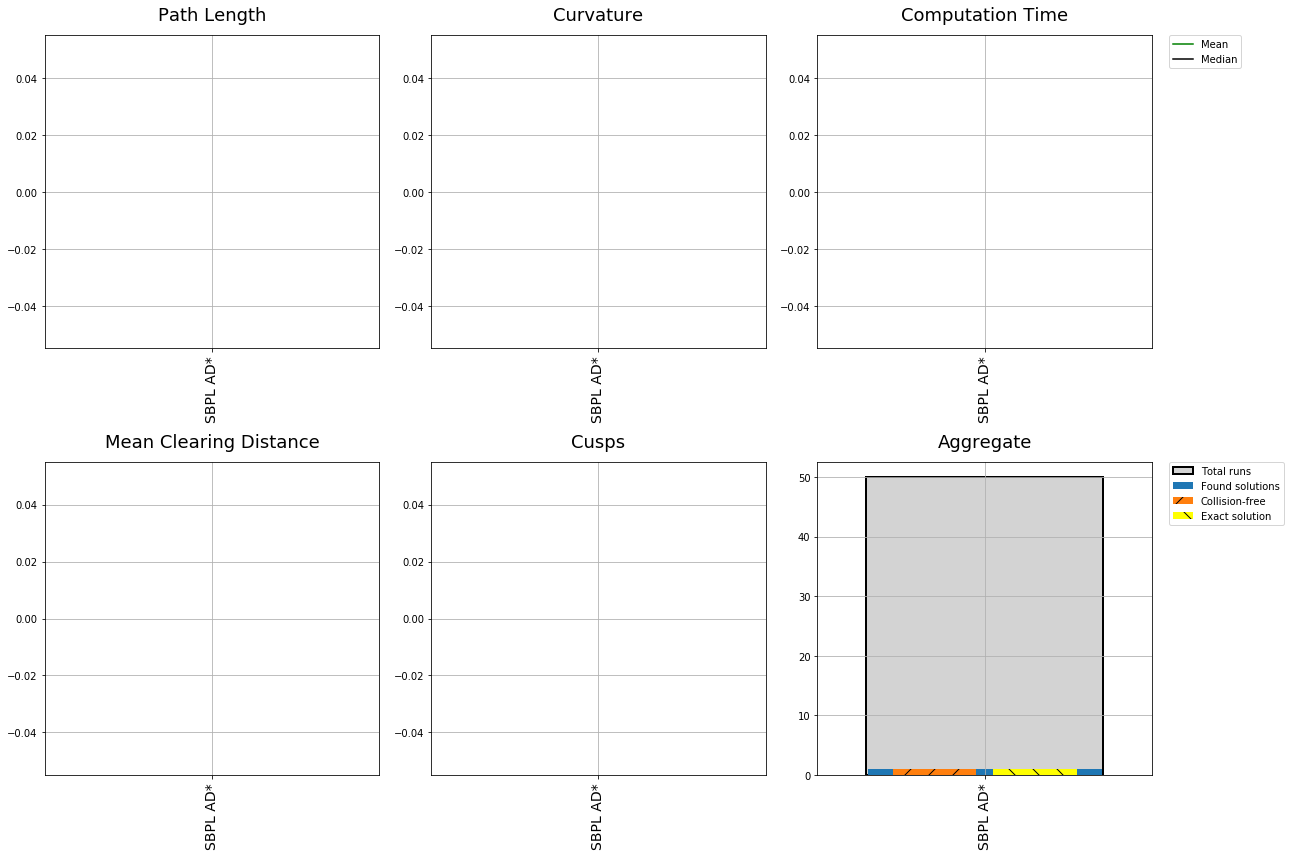

In [80]:
MPB.merge(pool.benchmarks, "moving_ai_%s_%s/total.json" % (scenario, steer_function), make_separate_runs=True)
from plot_stats import plot_planner_stats
plot_planner_stats("moving_ai_%s_%s/total.json" % (scenario, steer_function), save_file="moving_ai_%s_stats.pdf" % steer_function)

In [74]:
import json
from utils import convert_planner_name
planners = list(sorted(json.load(open(pool.benchmarks[0].results_filename))["runs"][0]["plans"].keys(), key=convert_planner_name))
print("Planners:", len(planners), planners)
print()
def latexify(planner: str):
    planner = convert_planner_name(planner)
    planner = planner.replace('#', '\\#')
    planner = planner.replace('*', '${}^*$')
    planner = planner.replace('_', '\\_')
    return planner
print('& \\databar{91.41} & \\databar{90.81} & \\databar{38.76} & \\databar{91.41} & \\databar{90.81} & \\databar{38.76}\\\\\n'.join(map(latexify, planners)))

Planners: 20 ['BFMT', 'kBITstar', 'CForest', 'EST', 'InformedRRTstar', 'KPIECE1', 'PDST', 'PRM', 'PRMstar', 'RRT', 'RRT#', 'RRTstar', 'SBPL_ADstar', 'SBPL_ARstar', 'SBPL_MHA', 'SORRTstar', 'SPARS', 'SPARStwo', 'SST', 'Theta*']

BFMT& \databar{91.41} & \databar{90.81} & \databar{38.76} & \databar{91.41} & \databar{90.81} & \databar{38.76}\\
BIT${}^*$& \databar{91.41} & \databar{90.81} & \databar{38.76} & \databar{91.41} & \databar{90.81} & \databar{38.76}\\
CForest& \databar{91.41} & \databar{90.81} & \databar{38.76} & \databar{91.41} & \databar{90.81} & \databar{38.76}\\
EST& \databar{91.41} & \databar{90.81} & \databar{38.76} & \databar{91.41} & \databar{90.81} & \databar{38.76}\\
Informed RRT${}^*$& \databar{91.41} & \databar{90.81} & \databar{38.76} & \databar{91.41} & \databar{90.81} & \databar{38.76}\\
KPIECE& \databar{91.41} & \databar{90.81} & \databar{38.76} & \databar{91.41} & \databar{90.81} & \databar{38.76}\\
PDST& \databar{91.41} & \databar{90.81} & \databar{38.76} & \data

In [55]:
metrics = ['path_found', 'planning_time', 'path_length', 'curvature', 'cusps']
stats = { metric: {planner: [] for planner in planners} for metric in metrics}
with open("moving_ai_%s_%s/total.json" % (scenario, steer_function), 'r') as rf:
    for run in json.load(rf)["runs"]:
        for planner, plan in run["plans"].items():
            for metric in metrics:
                if metric == 'path_found':
                    stats[metric][planner].append(int(plan["stats"][metric]))
                elif metric == "cusps":
                    stats[metric][planner].append(len(plan["stats"][metric]))
                else:
                    stats[metric][planner].append(plan["stats"][metric])

In [75]:
import numpy as np
def safe_mean(xs):
    return np.mean([x for x in xs if x is not None and not np.isnan(x)])
def safe_std(xs):
    return np.std([x for x in xs if x is not None and not np.isnan(x)])
def safe_sum(xs):
    return np.sum([x for x in xs if x is not None and not np.isnan(x)])

optimal_percentile = .05

metric_properties = {
    'path_found': {
        'sum': True
    },
    'planning_time': {
        'show_std': True,
        'max': config["max_planning_time"],
        'highlight_optimum': True
    },
    'path_length': {
        'show_std': True
    },
    'curvature': {
        'show_std': True,
        'minimize': True
    },
    'cusps': {
        'minimize': True,
        'sum': True
    }
}

for i, metric in enumerate(metrics):
    if "min" not in metric_properties[metric]:
        metric_properties[metric]["min"] = min([safe_mean(stats[metric][planner]) for planner in planners])
    if "max" not in metric_properties[metric]:
        metric_properties[metric]["max"] = max([safe_mean(stats[metric][planner]) for planner in planners])

for planner in planners:
    print(latexify(planner).ljust(40), '& %', convert_planner_name(planner))
    for i, metric in enumerate(metrics):
        mu = safe_mean(stats[metric][planner])
        line = '\t{\\databar{%.2f}}' % (min(1., mu / metric_properties[metric]["max"]))
        if metric_properties[metric].get("show_std", False):
            line += '\t%.2f \\pm %.2f' % (mu, safe_std(stats[metric][planner]))
        elif metric_properties[metric].get("percent", False):
            line += '\t%i \\%%' % (mu * 100)
        elif metric_properties[metric].get("sum", False):
            line += '\t%i' % (safe_sum(stats[metric][planner]))
        else:
            line += '\t%.2f' % safe_mean(stats[metric][planner])
        print(line, ('&' if i < len(metrics)-1 else '%'))
    print('\\\\')

BFMT                                     & % BFMT
	{\databar{0.98}}	49 &
	{\databar{0.06}}	0.92 \pm 0.94 &
	{\databar{0.32}}	370.66 \pm 8.98 &
	{\databar{0.18}}	0.36 \pm 0.16 &
	{\databar{0.14}}	159 %
\\
BIT${}^*$                                & % BIT*
	{\databar{0.98}}	49 &
	{\databar{1.00}}	15.03 \pm 0.04 &
	{\databar{0.32}}	365.69 \pm 9.76 &
	{\databar{0.17}}	0.34 \pm 0.14 &
	{\databar{0.10}}	118 %
\\
CForest                                  & % CForest
	{\databar{1.00}}	50 &
	{\databar{1.00}}	15.05 \pm 0.03 &
	{\databar{0.31}}	353.90 \pm 8.75 &
	{\databar{0.14}}	0.28 \pm 0.15 &
	{\databar{0.05}}	59 %
\\
EST                                      & % EST
	{\databar{1.00}}	50 &
	{\databar{0.03}}	0.47 \pm 1.06 &
	{\databar{0.49}}	572.13 \pm 125.58 &
	{\databar{0.16}}	0.33 \pm 0.07 &
	{\databar{0.39}}	444 %
\\
Informed RRT${}^*$                       & % Informed RRT*
	{\databar{1.00}}	50 &
	{\databar{1.00}}	15.01 \pm 0.01 &
	{\databar{0.30}}	351.95 \pm 11.38 &
	{\databar{0.14}}	0.27 \p

Visualizing moving_ai_reeds_shepp/moving_ai_reeds_shepp_19_results.json
Planner SBPL_ADstar found no solution!
Planner SBPL_ARstar found no solution!
Planner SBPL_MHA found no solution!


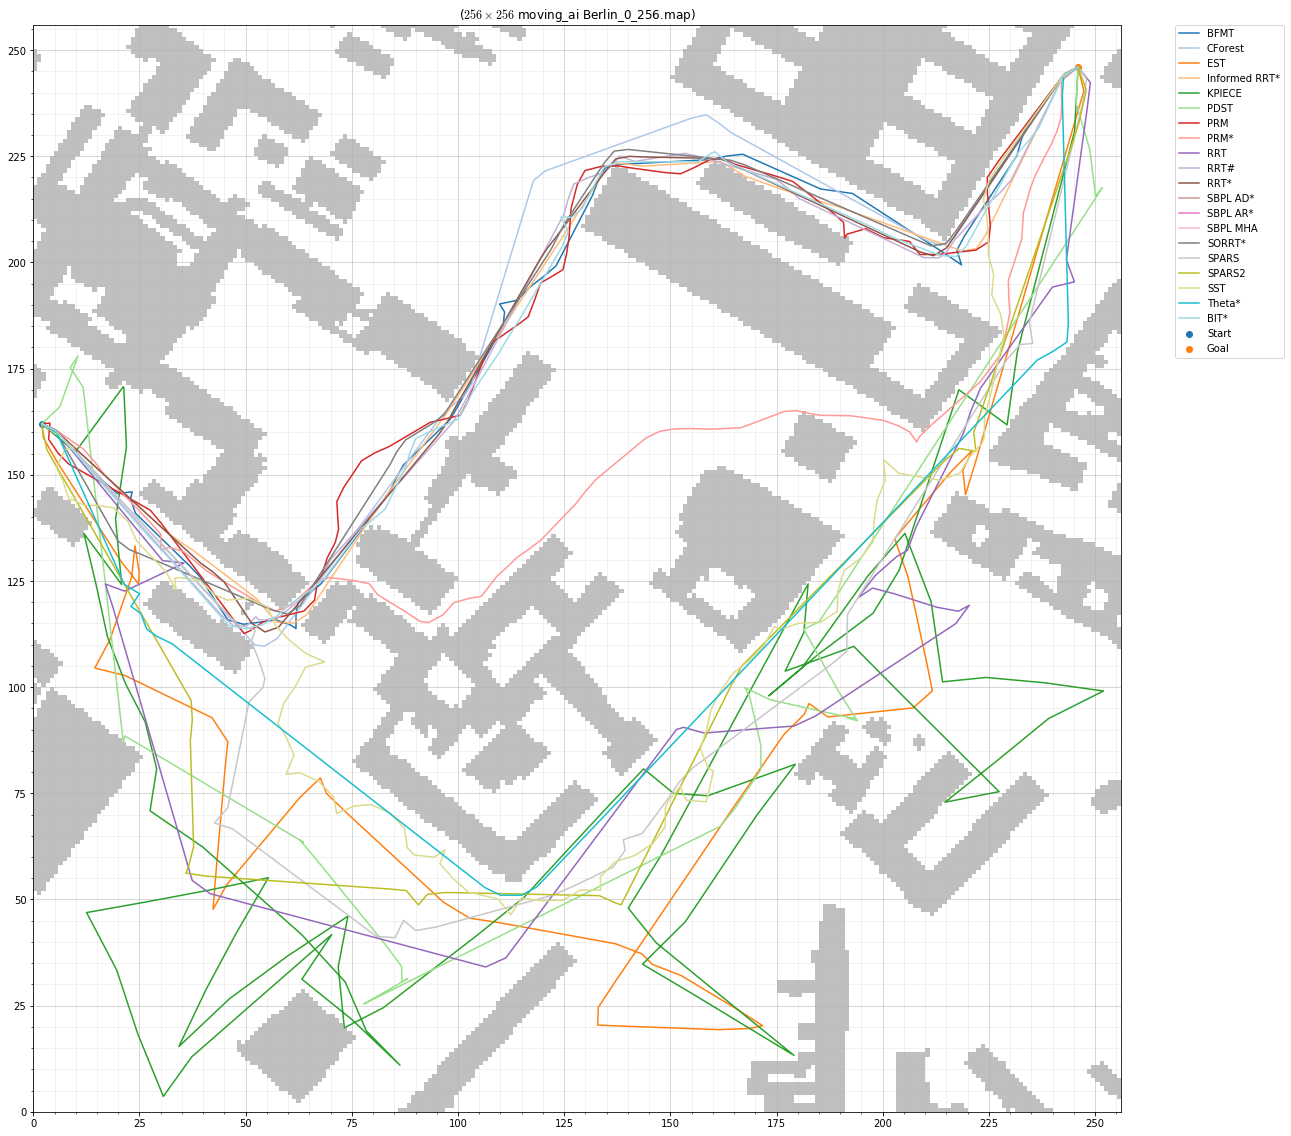

In [41]:
pool.benchmarks[19].visualize_trajectories(fig_width=20, fig_height=20)